In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from typing import List

In [ ]:
import numpy as np
import scipy.sparse as sp

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [ ]:
from textblob import TextBlob
from sentence_transformers import SentenceTransformer
from wordcloud import WordCloud

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
import time
from collections import Counter

### Датасет

568 454 пользовательских отзывов о продуктах питания, опубликованных на Amazon с 1999 по 2012 г.


Первоначальные столбцы:

1. Id – порядковый номер записи

2. ProductId – уникальный идентификатор товара

3. UserId, ProfileName – данные автора

4. HelpfulnessNumerator, HelpfulnessDenominator – «сколько людей посчитали отзыв полезным / всего проголосовавших»

5. Score – оценка 1 - 5 звёзд

6. Time – UNIX-время публикации

7. Summary – краткий заголовок

8. Text – полный текст отзыва

Самая большая сложность данной работы - определение нейтральных отзывов. Они являются самым маленьким классом (около 7 процентов от всех отзывов), содержат слова как с позитивной окраской так и с отрицательной.

### Задание 1

Подготовка и очистка текстов:

a.	Удалить пунктуацию, спецсимволы, лишние пробелы

b.	Привести текст к нижнему регистру

c.	Провести токенизацию, лемматизацию (с помощью nltk, spacy)

d.	Удалить стоп-слова


Загружаем стоп-слова, лемматизацию и токенизатор из nltk

In [ ]:
nltk.download('stopwords') #загрузка стоп-слов
nltk.download('wordnet') #загрузка лемматизации
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Расширяем список стоп-слов невошедшими в загруженный словарь, но портящими анализ данных своей частотой. Не все стоп-слова стоит использовать, в данном случае мы оставляем слова сомнений и противоречий для их учитывания в нейтральных отзывах.
Инициализируем стоп-слова и леммантизатор.

In [ ]:
# Расширяем список стоп-слов
#additional_stop_words = {'though', 'although'}
stop_words = set(stopwords.words('english'))
stop_words.difference_update({'but','further', 'should', 'than', 'where', 'why', 'then', 'such', 'other', 'because', 'how' })
lemmatizer = WordNetLemmatizer()

Предобработка текста.

Вначале текст приводится к нижнему регистру, затем регулярными выражениями удаляются HTML-теги, ссылки и вся пунктуация. Восклицательные и вопросительные знаки заменяются маркерами, чтобы не потерять их эмоциональную нагрузку. Далее выполняется токенизация, после чего из получившегося набора слов исключаются английские стоп-слова и слишком короткие токены, а оставшиеся лемматизируются WordNet-лемматизатором.

In [ ]:
print(stop_words)

{'nor', 'of', 'his', 'all', 'in', 'll', "they're", "we'd", 'while', 'so', 'having', 'shouldn', 'an', 'here', 'more', 'over', "mightn't", 'and', 'my', 'above', 'needn', 'each', 'o', 'had', "you'll", "doesn't", "i'll", "weren't", 'on', 'does', 'very', "shouldn't", 'your', "they'll", 'themselves', 'too', 'do', 'hasn', "haven't", 'this', "we've", 'at', 'for', 'again', 'it', 'm', 'she', 'what', "you've", "aren't", 'those', "couldn't", "he's", 'if', 'up', 'has', 'down', 'haven', "i've", "don't", "won't", 'mightn', 'shan', 'ain', 'he', 'myself', 'out', 'isn', 'am', 'against', "shan't", 'wasn', 'her', 'from', 'now', "it'd", 'our', 'until', 'couldn', 'i', 'between', 'himself', 'or', 't', 'yourselves', 'was', 'off', "they've", 'herself', "she'll", 'own', 'that', 'were', 'not', 'whom', 'y', 'as', 's', 'theirs', 'their', 'have', 'who', 'did', 'ours', "it'll", 'aren', "i'm", "isn't", 'won', 'a', 'once', 'we', 'just', 'its', 'few', 'd', 'been', 'they', 'him', "that'll", 'be', 'can', 'you', "she's", 

In [ ]:
def preprocess_text(text: str) -> List[str]:
    #Приведение к нижнему регистру
    text = text.lower()

    # Удаление HTML и ссылок
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'&[a-z]+;', ' ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)

    # Удаление остальной пунктуации
    text = re.sub(r'[^\w\s!?]', ' ', text)
    text = ' '.join(text.split())

    text = text.replace('!', ' exclamation_mark')
    text = text.replace('?', ' question_mark')
    # Токенизация
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Лемматизация с сохранением важных слов
    tokens = [lemmatizer.lemmatize(token) for token in tokens
              if token not in stop_words and len(token) > 2]

    return tokens

По причине ошибки работы google collab нет возможности обработать все данные, берем значительную выборку из 200 000 отзывов.

In [ ]:
df = pd.read_csv('/content/Reviews.csv')

df = df.head(200000)

print("\n10 Оригинальных отзывов:")
print("=" * 80)
for i, review in enumerate(df['Text'].head(10)):
    print(f"\nОригинальный отзыв {i+1}:")
    print(review)

df['Tokens'] = df['Text'].apply(preprocess_text)
df['Processed_Text'] = df['Tokens'].apply(lambda x: ' '.join(x))

print("\n10 Обработанных отзывов:")
print("=" * 80)
for i, tokens in enumerate(df['Tokens'].head(10)):
    print(f"\nОбработанный отзыв {i+1}:")
    print(tokens)



10 Оригинальных отзывов:

Оригинальный отзыв 1:
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Оригинальный отзыв 2:
Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

Оригинальный отзыв 3:
This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Ed

Также сразу рассмотрим самые популярные слов в отзывах, чтобы узнать могут ли они помочь на с составлением feature

In [ ]:
def print_top_neutral_words(df, top_n=100):
    """
    Выводит топ-N самых популярных слов в нейтральных отзывах.
    """
    # Берём очищенные тексты нейтральных отзывов
    neutral_reviews = df[df['Score'] == 3]['Processed_Text']

    # Собираем все слова в один список
    all_words = []
    for review in neutral_reviews.dropna():
        all_words.extend(review.split())

    # Считаем частоты
    from collections import Counter
    word_counts = Counter(all_words)

    # Получаем топ-N
    top_words = word_counts.most_common(top_n)

    print(f"Топ {top_n} самых популярных слов в нейтральных отзывах:")
    print("=" * 50)
    for i, (word, count) in enumerate(top_words, 1):
        print(f"{i:2d}. {word:20s} {count}")

In [ ]:
print_top_neutral_words(df, top_n=20)

Топ 20 самых популярных слов в нейтральных отзывах:
 1. like                 10615
 2. taste                8815
 3. coffee               8243
 4. flavor               7472
 5. good                 6965
 6. product              6203
 7. one                  6096
 8. would                5907
 9. exclamation_mark     4876
10. food                 4162
11. get                  4014
12. much                 3960
13. tea                  3826
14. really               3766
15. dog                  3355
16. cup                  3217
17. better               3143
18. make                 3133
19. little               3039
20. time                 2977


Как и ожидалось нейтральные отзывы не выделяют конкретные слова, используются разные эмоциональные спектры и информация о продуктах. Восклицательные знаки встечаются довольно редко.

В количествах слов в отзывах есть разброс, большинство отзывов составляют 20-30 слов, но есть определенные выбросы до 2000 слов, с их учетом добавляем фильтрацию для удобства анализа количества слов в отзывах. Используем квантиль  0.85, чтобы не терять типичные отзывы.

In [ ]:
def apply_outlier_removal_to_dataset(df):

    df_actual = df

    # Создаем копию DataFrame для безопасной работы
    df_copy = df_actual.copy()

    # Считаем количество слов в каждом отзыве
    # Используем .str.len() для работы с Series, содержащими списки
    df_copy['word_count'] = df_copy['Tokens'].str.len()

    # Находим 85-й квантиль
    upper_quantile = df_copy['word_count'].quantile(0.85)

    # Фильтруем выбросы
    df_clean = df_copy[df_copy['word_count'] <= upper_quantile].copy()

    # Статистика по выбросам
    num_outliers = (df_copy['word_count'] > upper_quantile).sum()
    outlier_stats = {
        'upper_quantile': upper_quantile,
        'num_outliers': num_outliers,
        'original_size': len(df_copy),
        'cleaned_size': len(df_clean)
    }

    return df_clean, outlier_stats

In [ ]:
# Применяем функцию удаления выбросов
df_clean, outlier_stats = apply_outlier_removal_to_dataset(df)

# Выводим статистику
print("Статистика удаления выбросов:")
print(f"Верхний квантиль (85%): {outlier_stats['upper_quantile']:.0f} слов")
print(f"Количество выбросов: {outlier_stats['num_outliers']:,}")
print(f"Исходный размер: {outlier_stats['original_size']:,}")
print(f"Размер после очистки: {outlier_stats['cleaned_size']:,}")
print(f"Удалено: {outlier_stats['num_outliers']:,} отзывов ({(outlier_stats['num_outliers']/outlier_stats['original_size']*100):.1f}%)")

# Обновляем рабочий датафрейм
df = df_clean.copy()

Статистика удаления выбросов:
Верхний квантиль (85%): 66 слов
Количество выбросов: 29,784
Исходный размер: 200,000
Размер после очистки: 170,216
Удалено: 29,784 отзывов (14.9%)


Текст успешно предобработан, стал чище, подходит для дальнейшей работы

### Задание 2

Разведочный анализ текстов (EDA):

a.	Вычислить длину отзывов (в словах/символах), построить распределения

b.	Построить облака слов (wordcloud) и графики частотности

c.	Исследовать взаимосвязь между оценкой (Rating) и длиной


Функция для анализа длинн текстов. Сначала считает для каждого текста число токенов и суммарную длину этих токенов в символах, после чего визуализирует оба показателя гистограммами, дополняя их линиями среднего и медианы для наглядной оценки центра распределений.

In [ ]:
def analyze_text_lengths(df):
    # Вычисляем длину в словах и символах
    df['word_count'] = df['Tokens'].str.len()
    df['char_count'] = df['Tokens'].apply(lambda x: sum(len(token) for token in x))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Распределение длины в словах
    sns.histplot(data=df, x='word_count', bins=30, ax=ax1,
                color='skyblue', edgecolor='black')
    ax1.set_title('Распределение длины отзывов (в словах)\nбез выбросов')
    ax1.set_xlabel('Количество слов')
    ax1.set_ylabel('Частота')

    # Добавляем вертикальные линии для среднего и медианы
    mean_words = df['word_count'].mean()
    median_words = df['word_count'].median()
    ax1.axvline(mean_words, color='red', linestyle='--', alpha=0.5,
                label=f'Среднее: {mean_words:.1f}')
    ax1.axvline(median_words, color='green', linestyle='--', alpha=0.5,
                label=f'Медиана: {median_words:.1f}')
    ax1.legend()

    # Распределение длины в символах
    sns.histplot(data=df, x='char_count', bins=30, ax=ax2,
                color='lightgreen', edgecolor='black')
    ax2.set_title('Распределение длины отзывов (в символах)\nбез выбросов')
    ax2.set_xlabel('Количество символов')
    ax2.set_ylabel('Частота')

    # Добавляем вертикальные линии для среднего и медианы
    mean_chars = df['char_count'].mean()
    median_chars = df['char_count'].median()
    ax2.axvline(mean_chars, color='red', linestyle='--', alpha=0.5,
                label=f'Среднее: {mean_chars:.1f}')
    ax2.axvline(median_chars, color='green', linestyle='--', alpha=0.5,
                label=f'Медиана: {median_chars:.1f}')
    ax2.legend()

    # Добавляем информацию о выбросах
    outliers_words = len(df) - len(df)
    outliers_percent = (outliers_words / len(df)) * 100

    fig.suptitle(f'Распределение длины отзывов\n', y=1.05)

    plt.tight_layout()
    plt.show()


    return df

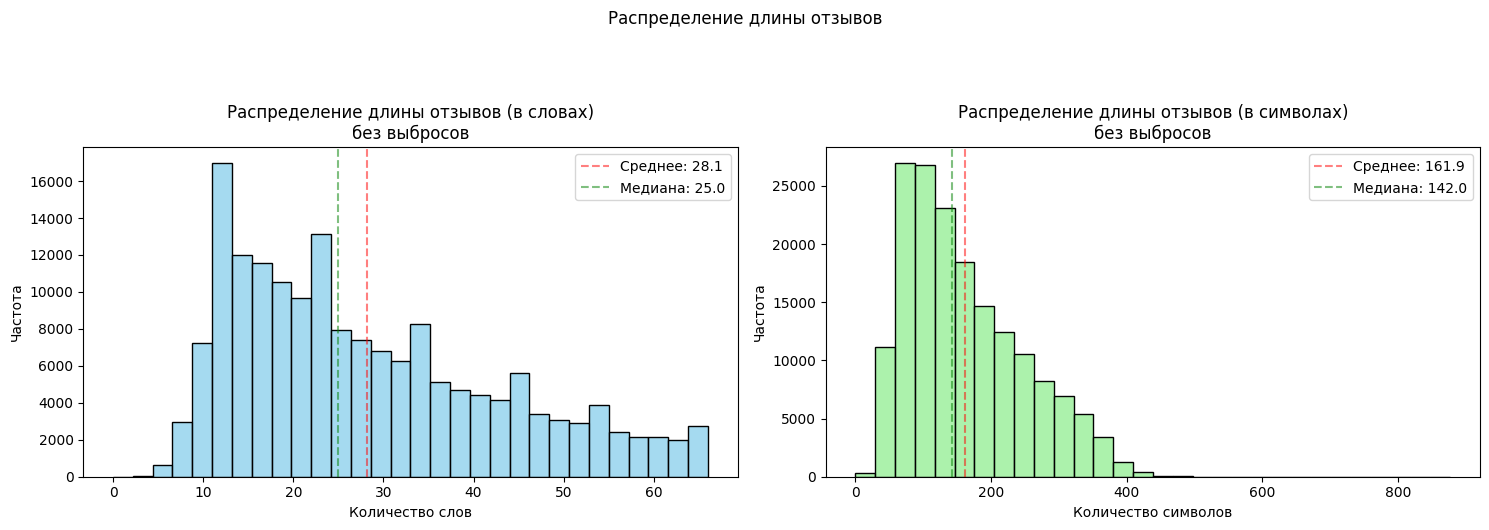

In [ ]:
analyze_text_lengths(df);

Видим что тексты преимущественно небольшие

Для создания облака слов использовали Counter() и подавали данные батчами, чтобы избежать ошибки памяти.

In [ ]:
def create_wordcloud(df, max_words=1000, batch_size=1000):
    # Создание облака слов с обработкой всех текстов порциями для экономии памяти

    # Инициализируем счетчик для подсчета частоты слов
    word_freq = Counter()
    custom_stopwords = {"exclamation_mark", "question_mark"}

    for i in range(0, len(df), batch_size):
        # Берем текущую порцию данных
        batch = df.iloc[i:i + batch_size]
        # Объединяем токены из текущей порции
        batch_text = ' '.join([' '.join(tokens) for tokens in batch['Tokens'].dropna()])
        # Обновляем счетчик частоты слов
        word_freq.update(batch_text.split())

    # Удаляем стоп-слова из счетчика частот
    for stopword in custom_stopwords:
        if stopword in word_freq:
            del word_freq[stopword]

    # Создаем облако слов на основе накопленной частоты слов
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=max_words,
        contour_width=3,
        contour_color='steelblue',
        collocations=False,
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Облако слов из всех отзывов')
    plt.show()

    # Выводим статистику
    total_words = sum(word_freq.values())
    unique_words = len(word_freq)
    print(f"\nСтатистика облака слов:")
    print(f"Всего слов: {total_words:,}")
    print(f"Уникальных слов: {unique_words:,}")
    print(f"Отображено слов в облаке: {max_words:,}")

    print("\nТоп-10 самых частых слов:")
    for word, freq in word_freq.most_common(10):
        print(f"{word}: {freq:,} раз")

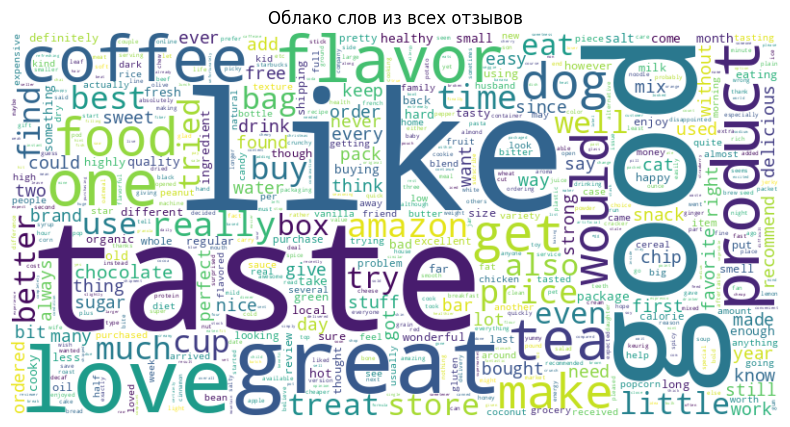


Статистика облака слов:
Всего слов: 4,667,178
Уникальных слов: 49,131
Отображено слов в облаке: 1,000

Топ-10 самых частых слов:
like: 61,395 раз
taste: 52,146 раз
good: 50,759 раз
great: 47,259 раз
love: 46,508 раз
flavor: 43,887 раз
product: 43,840 раз
coffee: 43,116 раз
one: 41,876 раз
tea: 33,676 раз


In [ ]:
create_wordcloud(df, max_words=1000, batch_size=1000)

Частотное ядро формируют слова, связанные со вкусовыми впечатлениями и положительной оценкой. Лидирующие «like», «taste», «good», «great», «love» сигнализируют о преобладании позитивных эмоциональных реакций.

Так же с помощью Counter() подсчитываем частоту слов

In [ ]:
def plot_word_frequencies(df):
    custom_stopwords = {"exclamation_mark", "question_mark"}
    # Объединяем все токены
    all_words = [word for tokens in df['Tokens'].dropna() for word in tokens]

    # Считаем частоту слов
    word_freq = Counter(all_words)

    for stopword in custom_stopwords:
        if stopword in word_freq:
            del word_freq[stopword]

    # Берем топ-20 слов
    top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
    words, freqs = zip(*top_words)

    # Строим график
    plt.figure(figsize=(12, 6))
    plt.bar(words, freqs)
    plt.xticks(rotation=45, ha='right')
    plt.title('Топ-20 самых частых слов')
    plt.xlabel('Слова')
    plt.ylabel('Частота')
    plt.tight_layout()
    plt.show()

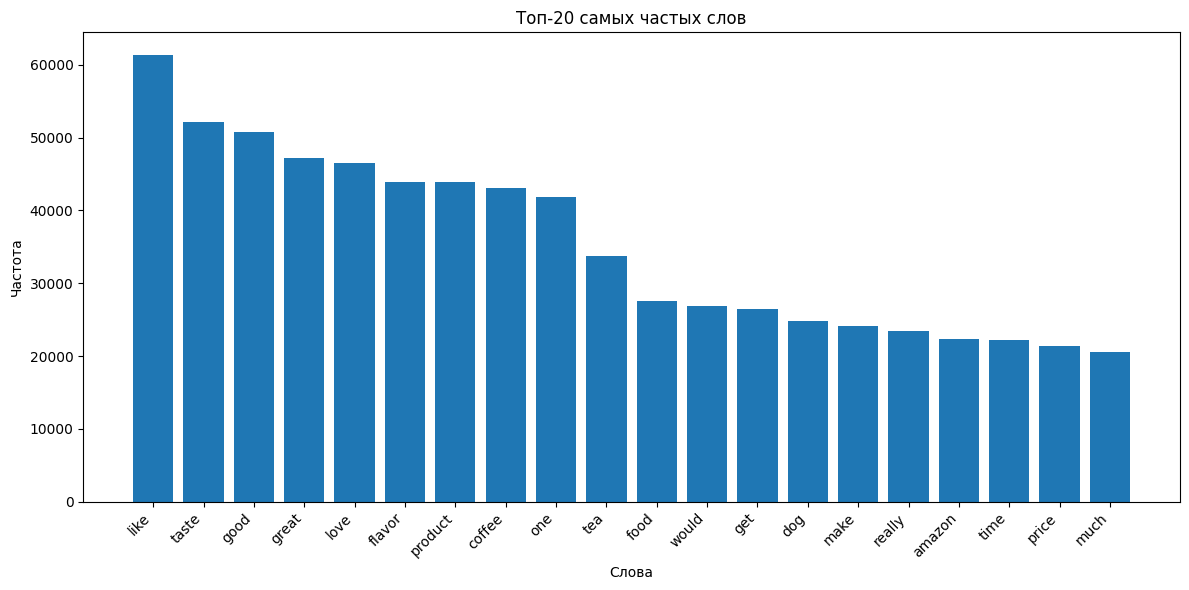

In [ ]:
plot_word_frequencies(df)

In [ ]:
def analyze_rating_length_correlation(df):
    # Точечный график
    sns.boxplot(data=df, x='Score', y='word_count')
    plt.title('Зависимость длины отзыва от оценки')
    plt.xlabel('Оценка')
    plt.ylabel('Количество слов')

    plt.tight_layout()
    plt.show()

    # Вычисляем корреляцию
    correlation = df['Score'].corr(df['word_count'])
    print(f"\nКорреляция между оценкой и длиной отзыва: {correlation:.3f}")

Выводы аналогичные тем, что были сделаны в облаке.

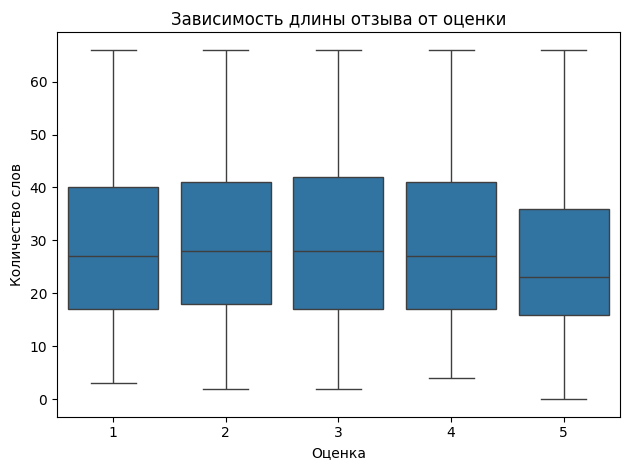


Корреляция между оценкой и длиной отзыва: -0.074


In [ ]:
analyze_rating_length_correlation(df)

Значение близко к нулю и указывает на почти полное отсутствие связи между количеством слов и поставленной оценкой: как короткие, так и длинные тексты встречаются при любых баллах. Хотя небольшая разница заметна: самые плохие отзывы и самые хорошие отзывы имеют чуть большую длину, чем менее критичные и нейтральные отзывы. Это можно объяснить психологией людей, что они более склонны к детальному описанию своего опыта при ярких эмоциях - позитивных или негативных.

### Задание 3

Преобразовать текст в числовое представление

a. TF-IDF — TfidfVectorizer из sklearn

b. Word2Vec, BERT embeddings — по желанию

c. длина текста, число положительных слов и т.п



Как было упомянуто ранее в нейтральных текстах часто присутствуют слова как позитивной, так и негативной окраски, поэтому важен контекст, tf-idf с этим справляется плохо, поэтому в качестве дополнительных feature используется Sentence-BERT эмбеддинги

In [ ]:
def generate_sentence_embeddings(texts, model_name: str = "all-MiniLM-L6-v2"):
    print("\nСоздание контекстных эмбеддингов SBERT (", model_name, ")")
    sbert_model = SentenceTransformer(model_name, device='cuda')
    # Преобразуем в список python-строк на случай pandas-Series
    embeddings = sbert_model.encode(list(texts), show_progress_bar=True, batch_size=64)
    return np.array(embeddings)

Функция для использования textBlob. Конкретно получение полярности и субъективности текстов. Описаны далее.

In [ ]:
    # Полярность и субъективность по TextBlob для каждого отзыва
    def _tb_scores(text: str):
            blob = TextBlob(text)
            return blob.sentiment.polarity, blob.sentiment.subjectivity

Функция создания вектора признаков.

За основу признаков взят tf-idf.

Далее статистические признаки

1. char_count — длина текста всловах в некоторой степени коррелирует c Score.
2. avg_word_length — сложные слова чаще встречаются при отсутствии эмоций.

Пунктуация
1. exclamation_count и question_count — При предобработке были оставлены восклицательные и вопросительные знаки для определения тональности. Недовольные покупатели чаще задают вопросы, а счастливые используют восклицания.
2. emotion_intensity — нормируем на длину, чтобы длинные тексты не доминировали

Семантика через TextBlob
Выбрана, потому что быстро считается и даёт две скалярные оценки:
1. polarity(-1...1) - положительность или отрицательность с помощью библиотеки Textblob
2. subjectivity (0...1) - объективность или субъективность т.е наполненность чувствами текста
2. polarity_abs - абсолютное значение полярности, которое игнорирует направление (положительное или отрицательное), но указывает на интенсивность чувства
3. subjectivity_score -  jценка нейтральности показывает, насколько текст приближен к нейтральному настроению
moderation_score - jценка объективности показывает, насколько объективен текст.


In [ ]:
def create_features_improved(df):

    print("Создание признаков")

    print("1. СозданиеTF-IDF признаков")

    # Основной TF-IDF с расширенными параметрами
    tfidf_main = TfidfVectorizer(
        max_features=10000,
        min_df=2,
        max_df=0.85,
        ngram_range=(1, 3),
        sublinear_tf=True,
        analyzer='word',
        norm='l2'
    )

    processed_texts = df['Tokens'].apply(lambda x: ' '.join(x))
    tfidf_main_matrix = tfidf_main.fit_transform(processed_texts)

    # ----  КОНТЕКСТНЫЕ ЭМБЕДДИНГИ SBERT  ----
    sbert_embeddings = generate_sentence_embeddings(processed_texts)
    # Нормируем, чтобы не доминировали над sparse-частью
    sbert_embeddings_scaled = StandardScaler().fit_transform(sbert_embeddings)

    print(f"SBERT embeddings shape: {sbert_embeddings_scaled.shape}")

    # Преобразуем dense -> sparse, чтобы hstack со sparse TF-IDF
    sbert_sparse = sp.csr_matrix(sbert_embeddings_scaled)

    print("2. Создание статистических признаков")

    # Базовые статистики
    word_count = processed_texts.str.split().str.len().values
    char_count = processed_texts.str.len().values

    # Средняя длина слов
    avg_word_length = processed_texts.str.split().apply(
        lambda x: np.mean([len(word) for word in x]) if x else 0
    ).values

    print("3. Создание пунктуационных признаков")

    # Подсчет знаков препинания
    exclamation_count = df['Text'].str.count('exclamation_mark').values
    question_count = df['Text'].str.count(r'question_mark').values

    # Интенсивность эмоций
    emotion_intensity = (exclamation_count) / (word_count + 1)

    print("4. Создание признаков TextBlob")

    tb_scores = np.array([_tb_scores(t) for t in processed_texts])  # shape (n_samples, 2)
    tb_polarity = tb_scores[:, 0]
    tb_subjectivity = tb_scores[:, 1]

    # Производные признаки
    tb_polarity_abs = np.abs(tb_polarity)
    tb_neutrality_score = 1 - tb_polarity_abs            # ближе к 1 -> ближе к нейтрали
    tb_moderation_score = 1 - tb_subjectivity            # объективность

    print("5. Объединение всех признаков")

    additional_features = np.column_stack([
        # Базовые статистики
        char_count, avg_word_length,

        # Пунктуационные признаки
        exclamation_count, question_count, emotion_intensity,

        tb_polarity, tb_subjectivity, tb_polarity_abs,
        tb_neutrality_score, tb_moderation_score

    ])

    # Нормализация
    scaler = StandardScaler()
    additional_features_scaled = scaler.fit_transform(additional_features)

    # Объединение всех TF-IDF, SBERT и дополнительных признаков
    from scipy.sparse import hstack, csr_matrix
    X = hstack([
        tfidf_main_matrix,
        sbert_sparse,
        csr_matrix(additional_features_scaled)
    ])


    print(f"TF-IDF: {tfidf_main_matrix.shape[1]} признаков")
    print(f"SBERT: {sbert_sparse.shape[1]} признаков")
    print(f"Дополнительные: {additional_features.shape[1]} признаков")

    return X, tfidf_main, scaler, additional_features

In [ ]:
# Создаем признаки
X, tfidf_vectorizer, scaler, additional_features = create_features_improved(df)

Создание признаков
1. СозданиеTF-IDF признаков

Создание контекстных эмбеддингов SBERT ( all-MiniLM-L6-v2 )


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2660 [00:00<?, ?it/s]

SBERT embeddings shape: (170216, 384)
2. Создание статистических признаков
3. Создание пунктуационных признаков
4. Создание признаков TextBlob
5. Объединение всех признаков
TF-IDF: 10000 признаков
SBERT: 384 признаков
Дополнительные: 10 признаков


### Задание 4
Формирование целевой переменной:

a.	На основе Rating разметить отзывы по классам

  1-2 — негативный

  3 — нейтральный

  4-5 — позитивный

b.	Проверить сбалансированность классов

c.	При необходимости — применить class_weight='balanced' или SMOTE.


Функция решает две основные задачи:
1. Превращает исходный 5-звёздочный рейтинг Amazon (Score) в трёхклассовую целевую переменную, совместимую с задачей.
2. Сразу же анализирует баланс классов.

In [ ]:
def create_target_variable(df):
    print("Создание целевой переменной")

    def categorize_sentiment(score):
        if score <= 2:
            return 0  # Негативный
        elif score == 3:
            return 1  # Нейтральный
        else:  # score >= 4
            return 2  # Позитивный

    df['sentiment'] = df['Score'].apply(categorize_sentiment)

    # Создаем текстовые метки
    sentiment_labels = {0: 'Негативный', 1: 'Нейтральный', 2: 'Позитивный'}
    df['sentiment_label'] = df['sentiment'].map(sentiment_labels)

    # Анализ распределения классов
    print("\nРаспределение классов:")
    class_counts = df['sentiment'].value_counts().sort_index()
    class_percentages = df['sentiment'].value_counts(normalize=True).sort_index() * 100

    for sentiment, label in sentiment_labels.items():
        count = class_counts[sentiment]
        percentage = class_percentages[sentiment]
        print(f"   {label}: {count:,} ({percentage:.1f}%)")

    # Визуализация
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    sentiment_counts = df['sentiment_label'].value_counts()
    colors = ['red', 'orange', 'green']
    ax1.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
    ax1.set_title('Распределение классов тональности')
    ax1.set_xlabel('Класс тональности')
    ax1.set_ylabel('Количество отзывов')

    for i, v in enumerate(sentiment_counts.values):
        ax1.text(i, v + max(sentiment_counts.values) * 0.01, f'{v:,}',
                ha='center', va='bottom')

    ax2.pie(sentiment_counts.values, labels=sentiment_counts.index,
            colors=colors, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Процентное распределение классов')

    plt.tight_layout()
    plt.show()

    # Проверка сбалансированности
    min_class = class_counts.min()
    max_class = class_counts.max()
    imbalance_ratio = max_class / min_class

    print(f"\nАнализ сбалансированности:")
    print(f"   Наименьший класс: {min_class:,} образцов")
    print(f"   Наибольший класс: {max_class:,} образцов")
    print(f"   Коэффициент дисбаланса: {imbalance_ratio:.2f}")

    needs_balancing = imbalance_ratio > 3

    return df, needs_balancing


Создание целевой переменной

Распределение классов:
   Негативный: 24,046 (14.1%)
   Нейтральный: 12,301 (7.2%)
   Позитивный: 133,869 (78.6%)


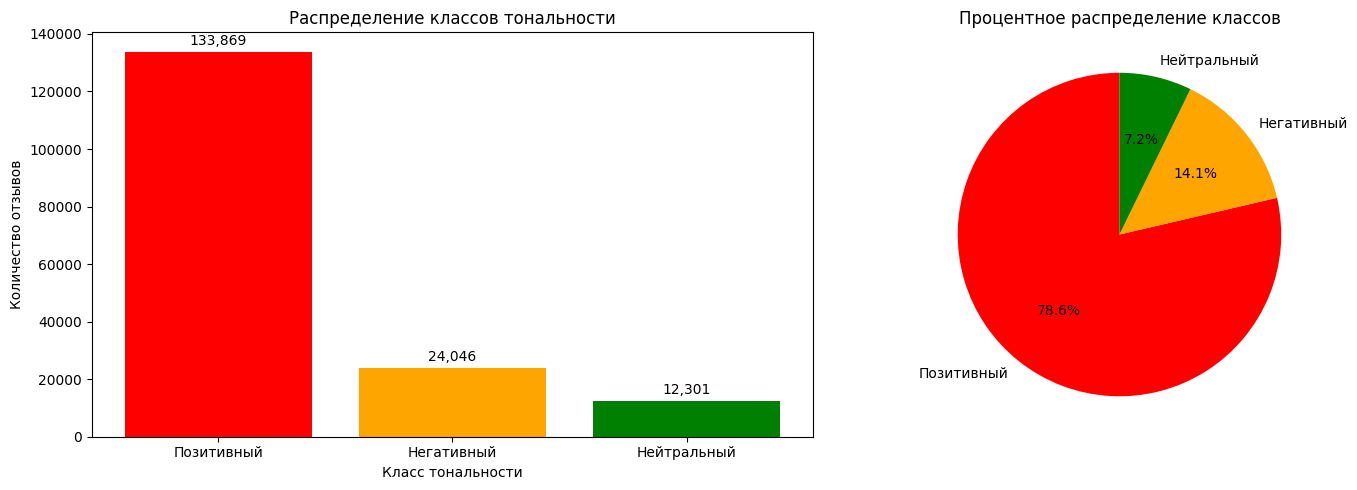


Анализ сбалансированности:
   Наименьший класс: 12,301 образцов
   Наибольший класс: 133,869 образцов
   Коэффициент дисбаланса: 10.88


In [ ]:
df, needs_balancing = create_target_variable(df)
y = df['sentiment'].values

Как мы видим из графиков классы критически несбалансированы. При обучении модели используется undersampling позитивных отзывов и oversampling нейтральных и негативных отзывов. Также были попытки использования перефразирований и генерации текстов, но они не дали значительного прироста к точности при значительном увеличении времени выполнения.

### Задание 5
Обучение моделей:

a.	Разделить выборку на обучающую и тестовую (например, 80/20)

b.	Обучить минимум одну классическую модель (LogisticRegression, SVM) и (по желанию) одну нейросетевую (BERT через HuggingFace)

c.	Оценить с помощью метрик

1. Accuracy

2. F1-score (по каждому классу)


Была использована логистическая регрессия в самых разных вариантах и с самыми разными параметрами, также былb протестированы
svm, ансамбли из моделей (2 слоя - определение нейтральный отзы или нет -> определение негативынй отзыв или нет к примеру) но ни оддна из них не дала результата точности определения больше 50% для нейтральных классов. Не найдено действенного метода определения нейтрального класса. В коде использована самая быстрая модель.
Также при низкой уаеренности модели, текст отмечается как нейтральный.

In [ ]:
def train_single_model(X, y, confidence_threshold: float = 0.45):

    start_time = time.time()

    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print(f"Размеры данных: Train={X_train.shape[0]:,}, Test={X_test.shape[0]:,}")

    # --- Балансировка классов: RUS для позитивных, ROS для негатив/нейтрал ---
    class_counter = Counter(y_train)
    pos_target = max(1, class_counter[2] // 3)
    rus = RandomUnderSampler(sampling_strategy={2: pos_target}, random_state=42)
    X_rus, y_rus = rus.fit_resample(X_train, y_train)

    class_counter_rus = Counter(y_rus)
    neg_target = class_counter_rus[0] * 2
    neu_target = class_counter_rus[1] * 3
    ros = RandomOverSampler(sampling_strategy={0: neg_target, 1: neu_target}, random_state=42)
    X_bal, y_bal = ros.fit_resample(X_rus, y_rus)

    print("\nПосле ресэмплинга:")
    for cls, cnt in sorted(Counter(y_bal).items()):
        cls_name = ['Негативный', 'Нейтральный', 'Позитивный'][cls]
        print(f"   {cls_name}: {cnt:,}")

    # Анализ распределения классов
    unique_classes, class_counts = np.unique(y_bal, return_counts=True)
    print(f"Распределение классов:")
    for class_id, count in zip(unique_classes, class_counts):
        class_name = ['Негативный', 'Нейтральный', 'Позитивный'][class_id]
        print(f"   {class_name}: {count:,} ({count/len(y_bal)*100:.1f}%)")

    # Создаем модель LogisticRegression с class_weight='balanced'
    model = LogisticRegression(
        max_iter=10000,
        random_state=42,
        solver='lbfgs',
        C=2,
        multi_class='multinomial',
        penalty='l2',
    )

    print("\n Обучение LogisticRegression")

    # Обучение модели
    model.fit(X_bal, y_bal)

    # Предсказания с учётом порога уверенности
    proba = model.predict_proba(X_test)
    max_proba = np.max(proba, axis=1)
    base_preds = np.argmax(proba, axis=1)
    # Если модель не уверена — присваиваем нейтральный класс (1)
    predictions = np.where(max_proba < confidence_threshold, 1, base_preds)
    print(f"\nПравило уверенности: если max(p) < {confidence_threshold}, класс -> Нейтральный")

    # Вычисление метрик
    accuracy = accuracy_score(y_test, predictions)
    f1_macro = f1_score(y_test, predictions, average='macro')
    f1_weighted = f1_score(y_test, predictions, average='weighted')
    f1_per_class = f1_score(y_test, predictions, average=None)

    training_time = time.time() - start_time

    print(f"Обучение завершено за {training_time:.2f}s")
    print(f"\n Результаты:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-macro: {f1_macro:.4f}")
    print(f"F1-weighted: {f1_weighted:.4f}")
    print(f"F1 по классам:")
    print(f"Негативный: {f1_per_class[0]:.4f}")
    print(f"Нейтральный: {f1_per_class[1]:.4f}")
    print(f"Позитивный: {f1_per_class[2]:.4f}")

    # Создаем результат в совместимом формате
    results = {
        'LogisticRegression_Balanced': {
            'model': model,
            'predictions': predictions,
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'f1_per_class': f1_per_class,
            'training_time': training_time,
            'balancing_method': 'RUS_pos_half_ROS_neg_neu_double',
            'confidence_threshold': confidence_threshold
        }
    }

    return results, X_test, y_test

In [ ]:
# Обучение модели
results, X_test, y_test = train_single_model(X, y)

Размеры данных: Train=119,151, Test=51,065

После ресэмплинга:
   Негативный: 33,664
   Нейтральный: 25,833
   Позитивный: 31,236
Распределение классов:
   Негативный: 33,664 (37.1%)
   Нейтральный: 25,833 (28.5%)
   Позитивный: 31,236 (34.4%)

 Обучение LogisticRegression

Правило уверенности: если max(p) < 0.45, класс -> Нейтральный
Обучение завершено за 441.67s

 Результаты:
Accuracy: 0.8017
F1-macro: 0.6520
F1-weighted: 0.8265
F1 по классам:
Негативный: 0.6916
Нейтральный: 0.3719
Позитивный: 0.8925


Хотя общая точность и удовлетворительна, это обуславливается большим количеством попаданий в положительные отзывы. Тончость определения нейтральныых отзывов составляет 0.4

В решениях с данным датасете на Kaggle также не найдено удовлетворительных результатов, там модели в основном не рассматривают нейтральную окраску текстов.

In [ ]:
def evaluate_single_model(results, y_test):
    print("\nОценка модели")
    print("=" * 60)

    sentiment_labels = ['Негативный', 'Нейтральный', 'Позитивный']

    model_name, result = list(results.items())[0]
    predictions = result['predictions']

    if result['training_time'] > 0:
        print(f"Время обучения: {result['training_time']:.2f}s")

    print(f"\nОсновные метрики:")
    print(f"   Accuracy: {result['accuracy']:.4f}")
    print(f"   F1-macro: {result['f1_macro']:.4f}")

    # Создаем subplot с 1 строкой и 2 колонками
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 1. F1-score по классам
    colors = ['#FF6B6B', '#FFA500', '#32CD32']
    f1_per_class = result['f1_per_class']  # Предполагаем, что это доступно
    bars = axes[0].bar(sentiment_labels, f1_per_class, color=colors, alpha=0.7)
    axes[0].set_title('F1-score по классам')
    axes[0].set_ylabel('F1-score')
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3)

    # Добавляем значения на столбцы
    for bar, value in zip(bars, f1_per_class):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # Выделяем нейтральные отзывы
    bars[1].set_edgecolor('black')
    bars[1].set_linewidth(3)

    # 2. Матрица ошибок
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sentiment_labels, yticklabels=sentiment_labels, ax=axes[1])
    axes[1].set_title('Матрица ошибок')
    axes[1].set_xlabel('Предсказанный класс')
    axes[1].set_ylabel('Истинный класс')

    plt.tight_layout()
    plt.show()

    return model_name


Оценка модели
Время обучения: 441.67s

Основные метрики:
   Accuracy: 0.8017
   F1-macro: 0.6520


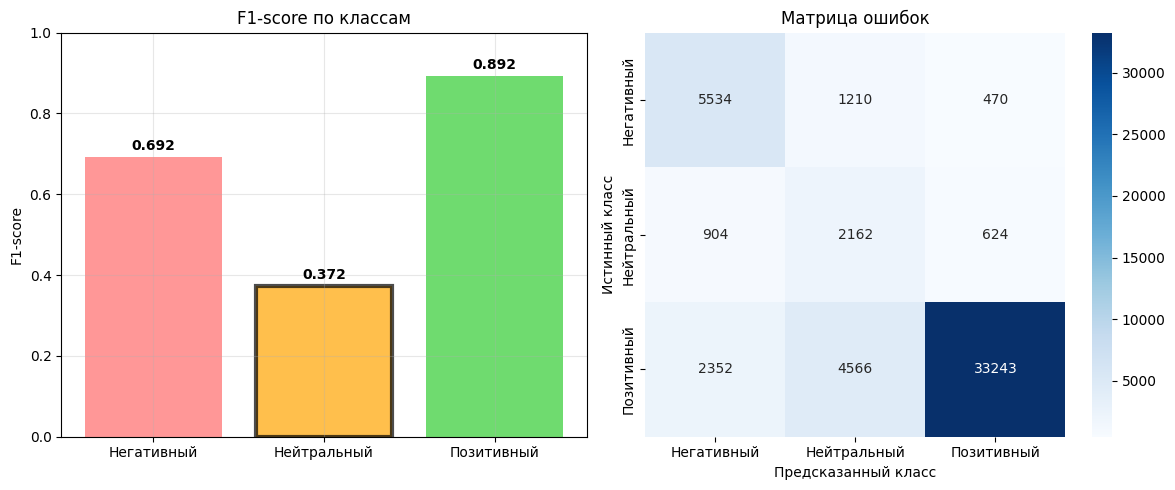

In [ ]:
# Оценка модели
best_model_name = evaluate_single_model(results, y_test)

best_model = results[best_model_name]['model']

По матрице ошибок можно понять что нейтральный отзыв чаще всего относит модель к положительному классу. Также иногда модель принимает позитивный класс за негативный. Это происходит скорее всего из-за того, что слова с позитивной окраской вроде like используются крайне часто во всех классах отзывов, на такие тексты модель соотносит позитивный класс.

### Задание 6
Интерпретация и визуализация:

a.	Визуализировать важные слова для каждого класса (coef_, SHAP, attention scores).

b.	Описать ключевые различия между отзывами разных тонов.


In [ ]:
def visualize_feature_importance(model, tfidf_vectorizer, model_name="LogisticRegression"):
    print(f"\nАнализ важности признаков")
    print("=" * 60)

    # Получаем веса признаков
    if hasattr(model, 'coef_'):
        coefficients = model.coef_
    else:
        print("Модель не поддерживает анализ коэффициентов")
        return None, None

    # Проверяем структуру коэффициентов
    print(f"Структура коэффициентов: {coefficients.shape}")

    # Получаем названия признаков (только TF-IDF)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    print(f"Количество TF-IDF признаков: {len(feature_names)}")

    sentiment_labels = ['Негативный', 'Нейтральный', 'Позитивный']

    # Для каждого класса найдем топ-слова
    top_n = 15

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for class_idx, (sentiment, ax) in enumerate(zip(sentiment_labels, axes)):
        # Берем коэффициенты для текущего класса
        class_coef = coefficients[class_idx, :len(feature_names)]

        # Получаем индексы топ-признаков
        top_indices = np.argsort(np.abs(class_coef))[-top_n:]
        top_features = [feature_names[i] for i in top_indices]
        top_coef = class_coef[top_indices]

        # Сортируем по значению коэффициента
        sorted_indices = np.argsort(top_coef)
        top_features_sorted = [top_features[i] for i in sorted_indices]
        top_coef_sorted = top_coef[sorted_indices]

        # Определяем цвета (положительные - зеленый, отрицательные - красный)
        colors = ['red' if coef < 0 else 'green' for coef in top_coef_sorted]

        # Строим горизонтальный барплот
        ax.barh(range(len(top_features_sorted)), top_coef_sorted, color=colors, alpha=0.7)
        ax.set_yticks(range(len(top_features_sorted)))
        ax.set_yticklabels(top_features_sorted)
        ax.set_xlabel('Коэффициент')
        ax.set_title(f'Топ-{top_n} слов для класса\n"{sentiment}"')
        ax.grid(True, alpha=0.3, axis='x')

        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Выводим топ-слова в текстовом виде
    print("\nТоп важных слов по классам:")
    print("-" * 60)

    for class_idx, sentiment in enumerate(sentiment_labels):
        # Берем коэффициенты для текущего класса
        if coefficients.ndim == 2:
            class_coef = coefficients[class_idx, :len(feature_names)]
        else:
            class_coef = coefficients[:len(feature_names)]

        # Положительные коэффициенты (способствуют классу)
        pos_indices = np.argsort(class_coef)[-10:]
        pos_features = [(feature_names[i], class_coef[i]) for i in pos_indices[::-1]]

        # Отрицательные коэффициенты (препятствуют классу)
        neg_indices = np.argsort(class_coef)[:10]
        neg_features = [(feature_names[i], class_coef[i]) for i in neg_indices]

        print(f"\n{sentiment}:")
        print(f"  Положительно влияющие слова:")
        for word, coef in pos_features:
            print(f"    {word}: {coef:.4f}")

        print(f"  Отрицательно влияющие слова:")
        for word, coef in neg_features:
            print(f"    {word}: {coef:.4f}")

    return coefficients, feature_names


In [ ]:
def create_sentiment_wordclouds(df):
    print("\nСоздание облаков слов по классам тональности")
    print("=" * 60)

    sentiment_labels = {0: 'Негативный', 1: 'Нейтральный', 2: 'Позитивный'}
    colors = {0: 'Reds', 1: 'Oranges', 2: 'Greens'}

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for sentiment_id, sentiment_name in sentiment_labels.items():
        # Фильтруем отзывы по тональности
        sentiment_reviews = df[df['sentiment'] == sentiment_id]

        # Объединяем все токены для данного класса
        all_tokens = []
        for tokens in sentiment_reviews['Tokens']:
            all_tokens.extend(tokens)

        # Создаем частотный словарь
        word_freq = Counter(all_tokens)

        # Создаем облако слов
        wordcloud = WordCloud(
            width=600,
            height=400,
            background_color='white',
            max_words=100,
            colormap=colors[sentiment_id],
            contour_width=1,
            contour_color='steelblue',
            collocations=False
        ).generate_from_frequencies(word_freq)

        # Отображаем облако слов
        axes[sentiment_id].imshow(wordcloud, interpolation='bilinear')
        axes[sentiment_id].axis('off')
        axes[sentiment_id].set_title(f'Облако слов - {sentiment_name}\n({len(sentiment_reviews):,} отзывов)')

        # Выводим статистику
        print(f"\n{sentiment_name}:")
        print(f"  Количество отзывов: {len(sentiment_reviews):,}")
        print(f"  Общее количество слов: {len(all_tokens):,}")
        print(f"  Уникальных слов: {len(word_freq):,}")
        print(f"  Топ-10 слов: {', '.join([word for word, _ in word_freq.most_common(10)])}")

    plt.tight_layout()
    plt.show()

    return sentiment_labels


По анализу мы видим, слова с соответсвующей эмоциональной окраской соответсвуют своим классам, здесь все логично.


Анализ важности признаков
Структура коэффициентов: (3, 10394)
Количество TF-IDF признаков: 10000


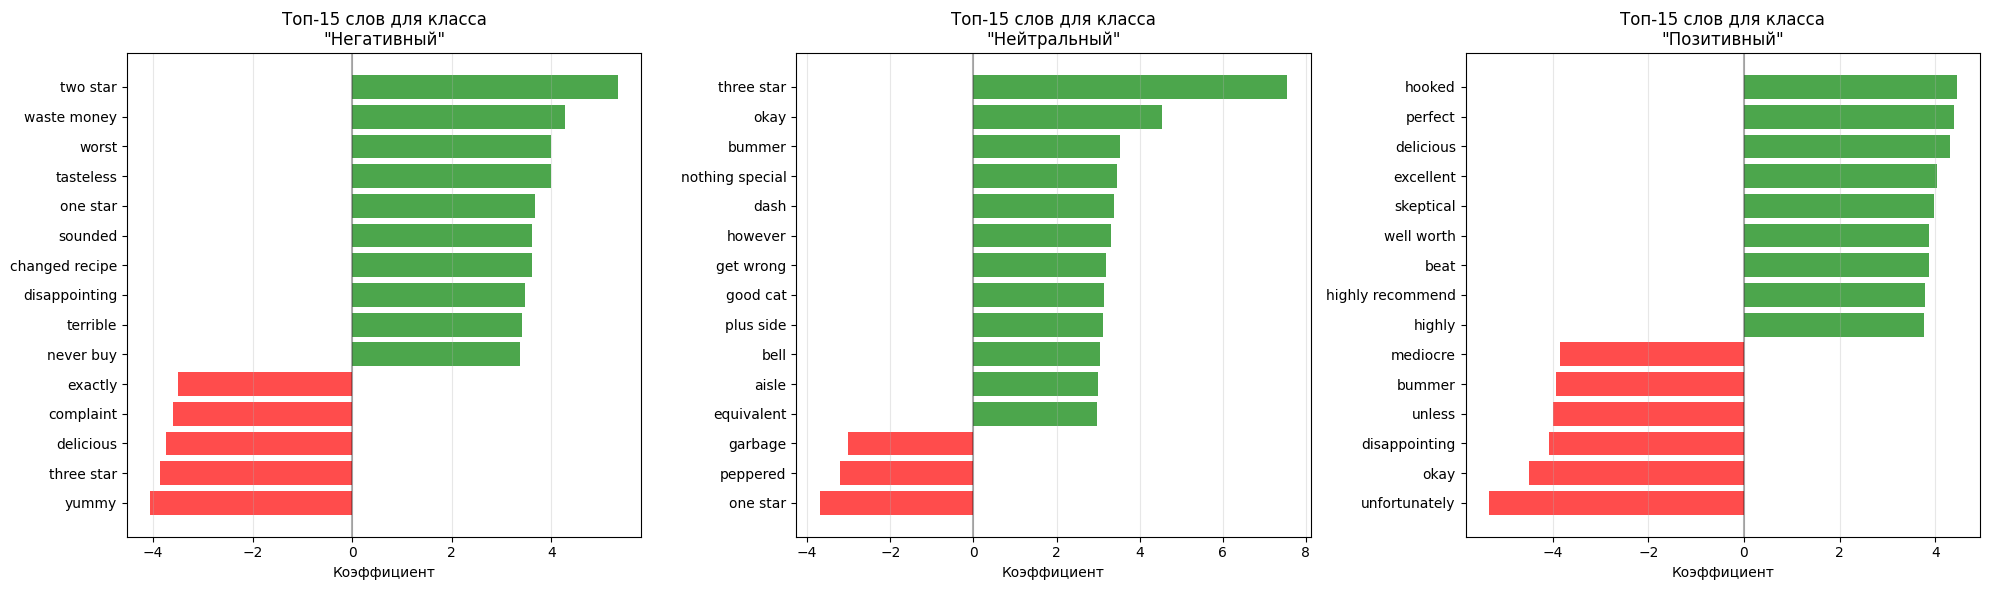


Топ важных слов по классам:
------------------------------------------------------------

Негативный:
  Положительно влияющие слова:
    two star: 5.3363
    waste money: 4.2820
    worst: 3.9972
    tasteless: 3.9891
    one star: 3.6663
    sounded: 3.6023
    changed recipe: 3.6005
    disappointing: 3.4661
    terrible: 3.4020
    never buy: 3.3738
  Отрицательно влияющие слова:
    yummy: -4.0507
    three star: -3.8635
    delicious: -3.7289
    complaint: -3.5904
    exactly: -3.4959
    great: -3.2805
    downside: -3.2251
    bit: -3.2116
    addicted: -3.0454
    overall: -3.0296

Нейтральный:
  Положительно влияющие слова:
    three star: 7.5542
    okay: 4.5448
    bummer: 3.5226
    nothing special: 3.4625
    dash: 3.3913
    however: 3.3124
    get wrong: 3.1976
    good cat: 3.1329
    plus side: 3.1067
    bell: 3.0525
  Отрицательно влияющие слова:
    one star: -3.7003
    peppered: -3.2224
    garbage: -3.0159
    loose leaf: -2.8721
    highly: -2.6747
    definit

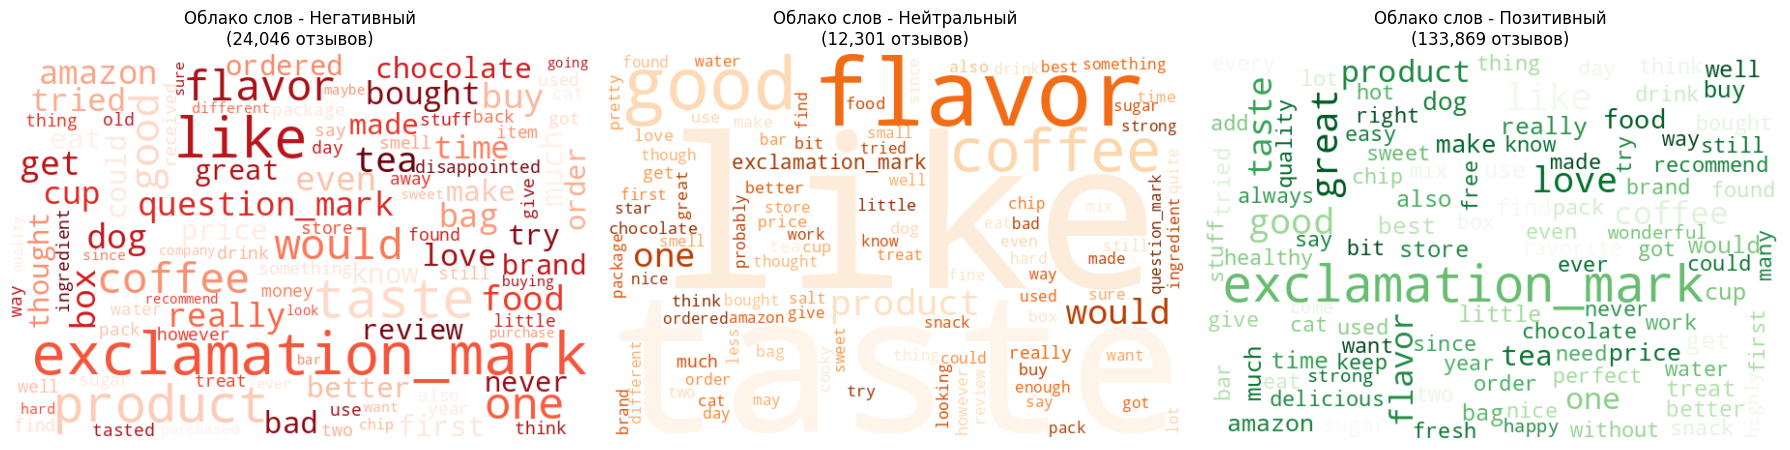

{0: 'Негативный', 1: 'Нейтральный', 2: 'Позитивный'}

In [ ]:
# Анализ важности признаков для обученной модели
coefficients, feature_names = visualize_feature_importance(best_model, tfidf_vectorizer)
# Создание облаков слов по классам
create_sentiment_wordclouds(df)

По облакам слов мы видим что во всех отзывах используется слово like, но просто в разных контекстах. Также в нейтральных и отрицательных отхывах чаще упоминается вкус и сам продукт. В позитивном классе чаще указываются ощущения. Также выделяется то, что в нейтральных классах не используется восклицательный знак.

In [ ]:
def analyze_sentiment_differences(df):

    print("\nАнализ различий между классами тональности")
    print("=" * 60)

    # Создаем сравнительную таблицу характеристик
    characteristics = []

    for sentiment_id in [0, 1, 2]:
        sentiment_data = df[df['sentiment'] == sentiment_id]
        sentiment_name = ['Негативный', 'Нейтральный', 'Позитивный'][sentiment_id]

        # Вычисляем характеристики
        avg_length = sentiment_data['word_count'].mean()
        avg_chars = sentiment_data['char_count'].mean()
        avg_exclamation = sentiment_data['Text'].str.count('!').mean()
        avg_question = sentiment_data['Text'].str.count(r'\\?').mean()

        # Полярность TextBlob
        sentiments = sentiment_data['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
        avg_polarity = sentiments.mean()

        characteristics.append({
            'Тональность': sentiment_name,
            'Средняя длина (слова)': avg_length,
            'Средняя длина (символы)': avg_chars,
            'Восклицательные знаки': avg_exclamation,
            'Вопросительные знаки': avg_question,
            'Полярность TextBlob': avg_polarity
        })

    comparison_df = pd.DataFrame(characteristics)

    print("\nСравнительная таблица характеристик:")
    print("-" * 80)
    for col in comparison_df.columns[1:]:
        print(f"\n{col}:")
        for _, row in comparison_df.iterrows():
            print(f"  {row['Тональность']:<12}: {row[col]:.3f}")

    # Визуализация различий была убрана по запросу. Вместо графиков выводим таблицу с характеристиками.
    print("\nТаблица характеристик без визуализации:\n")
    print(comparison_df.to_string(index=False))

    # Текстовое резюме ключевых различий
    print("\n Ключевые выводы:")
    print("-" * 40)

    # Анализ длины
    neg_length = comparison_df.iloc[0]['Средняя длина (слова)']
    neu_length = comparison_df.iloc[1]['Средняя длина (слова)']
    pos_length = comparison_df.iloc[2]['Средняя длина (слова)']

    # Анализ полярности
    neg_pol = comparison_df.iloc[0]['Полярность TextBlob']
    neu_pol = comparison_df.iloc[1]['Полярность TextBlob']
    pos_pol = comparison_df.iloc[2]['Полярность TextBlob']

    print(f"\nПолярность (TextBlob):")
    print(f"Негативные: {neg_pol:.3f}")
    print(f"Нейтральные: {neu_pol:.3f}")
    print(f"Позитивные: {pos_pol:.3f}")

    return comparison_df

In [ ]:
# Шаг 7: Анализ различий между классами тональности
comparison_df = analyze_sentiment_differences(df)


Анализ различий между классами тональности

Сравнительная таблица характеристик:
--------------------------------------------------------------------------------

Средняя длина (слова):
  Негативный  : 29.852
  Нейтральный : 30.603
  Позитивный  : 27.604

Средняя длина (символы):
  Негативный  : 171.998
  Нейтральный : 172.113
  Позитивный  : 159.120

Восклицательные знаки:
  Негативный  : 0.488
  Нейтральный : 0.242
  Позитивный  : 0.735

Вопросительные знаки:
  Негативный  : 333.210
  Нейтральный : 346.268
  Позитивный  : 297.623

Полярность TextBlob:
  Негативный  : 0.029
  Нейтральный : 0.161
  Позитивный  : 0.303

Таблица характеристик без визуализации:

Тональность  Средняя длина (слова)  Средняя длина (символы)  Восклицательные знаки  Вопросительные знаки  Полярность TextBlob
 Негативный              29.852366               171.998170               0.488480            333.209598             0.029126
Нейтральный              30.602553               172.113243               0.241

По результатам анализа мы видим, что полярность TextBlob действительно помогает различать классы, также есть зависимость в средней длине используемых слов, восклицательных знакахх.